In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [2]:
# book_df = pd.read_csv('Books.csv')
# ratings_df = pd.read_csv('Ratings.csv').sample(40000)
# user_df = pd.read_csv('Users.csv')
# user_rating_df = ratings_df.merge(user_df, left_on = 'User-ID', right_on = 'User-ID')

import pandas as pd

# Load the datasets with the 'python' engine
book_df = pd.read_csv('Books.csv', engine='python')
ratings_df = pd.read_csv('Ratings.csv', engine='python').sample(40000)
user_df = pd.read_csv('Users.csv', engine='python')

# Merge the datasets
user_rating_df = ratings_df.merge(user_df, left_on='User-ID', right_on='User-ID')

print(user_rating_df.head())


   User-ID        ISBN  Book-Rating                          Location   Age
0   245963  0345274237            0        saint louis, missouri, usa   NaN
1   105366  1558743316            0      midland, north carolina, usa   NaN
2   189666  2221068610            0  maastricht, limburg, netherlands   NaN
3   114298  1573440000            0             atlanta, georgia, usa  28.0
4   231827  0534593100            0             festus, missouri, usa  32.0


In [3]:
book_user_rating = book_df.merge(user_rating_df, left_on = 'ISBN',right_on = 'ISBN')
book_user_rating = book_user_rating[['ISBN', 'Book-Title', 'Book-Author', 'User-ID', 'Book-Rating']]
book_user_rating.reset_index(drop=True, inplace = True)

In [4]:
d ={}
for i,j in enumerate(book_user_rating.ISBN.unique()):
    d[j] =i
book_user_rating['unique_id_book'] = book_user_rating['ISBN'].map(d)

In [5]:
users_books_pivot_matrix_df = book_user_rating.pivot(index='User-ID', 
                                                          columns='unique_id_book', 
                                                          values='Book-Rating').fillna(0)

In [6]:
users_books_pivot_matrix_df.head()


unique_id_book,0,1,2,3,4,5,6,7,8,9,...,26033,26034,26035,26036,26037,26038,26039,26040,26041,26042
User-ID,,,,,,,,,,,,,,,,,,,,,
141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
users_books_pivot_matrix_df = users_books_pivot_matrix_df.values
users_books_pivot_matrix_df


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
from scipy.sparse.linalg import svds

NUMBER_OF_FACTORS_MF = 15

#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_books_pivot_matrix_df, k = NUMBER_OF_FACTORS_MF)

In [9]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [10]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[-3.17831797e-28, -1.99462593e-35,  3.43645651e-35, ...,
        -4.99418528e-37, -4.99418528e-37,  0.00000000e+00],
       [ 5.90938202e-29,  2.32128332e-34,  6.82455756e-36, ...,
        -4.87837515e-35, -4.87837515e-35,  0.00000000e+00],
       [ 1.40768398e-16, -4.16739136e-21,  7.36877020e-22, ...,
        -1.11976983e-21, -1.11976983e-21,  0.00000000e+00],
       ...,
       [-7.62312970e-28, -2.40898073e-34,  2.53143493e-35, ...,
        -6.66355883e-35, -6.66355883e-35,  0.00000000e+00],
       [-9.45953564e-28, -7.45693995e-35,  7.85372292e-35, ...,
        -1.83722595e-36, -1.83722595e-36,  0.00000000e+00],
       [ 6.35344034e-28,  9.97383986e-35, -5.30472888e-35, ...,
        -1.19289731e-37, -1.19289731e-37,  0.00000000e+00]])

In [11]:
def top_cosine_similarity(data, book_id, top_n=10):
    index = book_id 
    book_row = data[index, :]
    magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
    similarity = np.dot(book_row, data.T) / (magnitude[index] * magnitude)
    sort_indexes = np.argsort(-similarity)
    return sort_indexes[:top_n]

def similar_books(book_user_rating, book_id, top_indexes):
    print('Recommendations for {0}: \n'.format(
    book_user_rating[book_user_rating.unique_id_book == book_id]['Book-Title'].values[0]))
    for id in top_indexes + 1:
        print(book_user_rating[book_user_rating.unique_id_book == id]['Book-Title'].values[0])

In [12]:
k = 50
movie_id =25954  
top_n = 3
sliced = Vt.T[:, :k] # representative data

similar_books(book_user_rating, 25954, top_cosine_similarity(sliced, movie_id, top_n))

Recommendations for I'm Wild Again: 

The Testament
Beloved (Plume Contemporary Fiction)
New Vegetarian: Bold and Beautiful Recipes for Every Occasion


C:\Users\Sheikh Irtiza\AppData\Local\Temp\ipykernel_11340\437162856.py:5: RuntimeWarning: invalid value encountered in divide
  similarity = np.dot(book_row, data.T) / (magnitude[index] * magnitude)


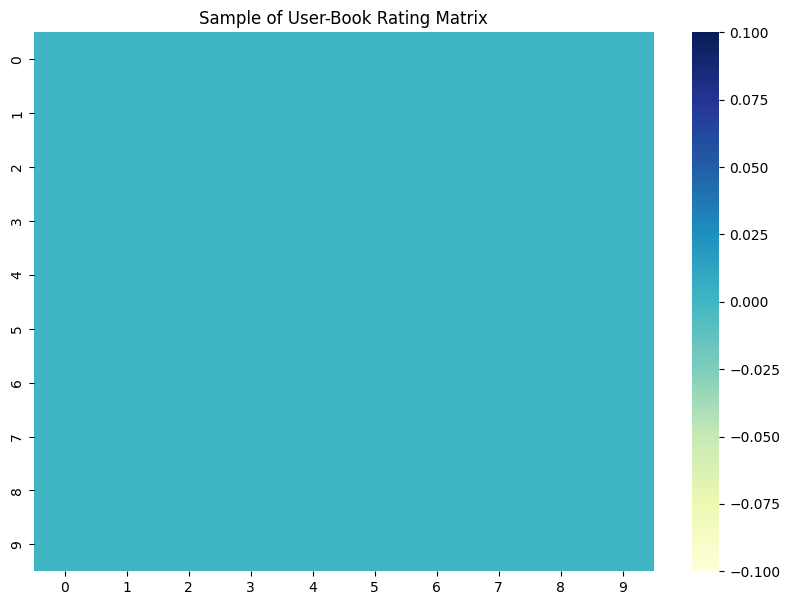

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_user_book_matrix(matrix):
    """
    Plot a heatmap of the user-zbook matrix.
    """
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix[:10, :10], cmap='YlGnBu', annot=False)
    plt.title('Sample of User-Book Rating Matrix')
    plt.show()

# Ensure you pass the correct matrix (users_books_pivot_matrix_df)
visualize_user_book_matrix(users_books_pivot_matrix_df)
